# Exploratory data analysis

Some exploration into the cleaned datasets `data/clean_data.csv`. It contains all of the flights minus the canceled ones, or ones with missing data in key columns, and only for the top 6 busiest airports in the US, and top 10 carriers.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

plt.style.use("default")
# plt.style.use("seaborn-v0_8-talk")
# plt.style.use("ggplot")
# plt.style.use("fivethirtyeight")
# plt.style.use("seaborn-v0_8-muted")

import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "mathtext.default": "regular",
    "xtick.direction" : "in",
    "ytick.direction" : "in",
    "xtick.top" : True,
    "ytick.right" : True,
    "axes.unicode_minus" : True
})

In [248]:
df = pd.read_csv("../data/clean_data.csv", parse_dates=[1])
df.info()

# Create delay column
delay_thresh=15.
df = df.assign(DELAY_TF=pd.Series(df['DEP_DELAY']>delay_thresh).values.astype(int))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10909889 entries, 0 to 10909888
Data columns (total 13 columns):
 #   Column               Dtype         
---  ------               -----         
 0   Unnamed: 0           int64         
 1   FL_DATE              datetime64[ns]
 2   OP_UNIQUE_CARRIER    object        
 3   ORIGIN_AIRPORT_ID    int64         
 4   DEST_AIRPORT_ID      int64         
 5   DEP_DELAY            float64       
 6   AIR_TIME             float64       
 7   CARRIER_DELAY        float64       
 8   WEATHER_DELAY        float64       
 9   NAS_DELAY            float64       
 10  SECURITY_DELAY       float64       
 11  LATE_AIRCRAFT_DELAY  float64       
 12  FRAC_YEAR            float64       
dtypes: datetime64[ns](1), float64(8), int64(3), object(1)
memory usage: 1.1+ GB


In [246]:
# df.head()
df.tail()

,Unnamed: 0,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,DEP_DELAY,AIR_TIME,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FRAC_YEAR
10909884,10909884,2023-08-31 18:33:00,WN,13930,12889,17.0,195.0,0.0,0.0,0.0,0.0,0.0,0.665131
10909885,10909885,2023-08-31 06:39:00,WN,13930,14107,6.0,196.0,0.0,0.0,0.0,0.0,0.0,0.663773
10909886,10909886,2023-08-31 13:32:00,WN,13930,14107,-2.0,187.0,0.0,0.0,0.0,0.0,0.0,0.664559
10909887,10909887,2023-08-31 17:37:00,WN,13930,14107,3.0,184.0,0.0,0.0,0.0,0.0,0.0,0.665025
10909888,10909888,2023-08-31 14:39:00,WN,13930,15304,6.0,131.0,0.0,0.0,0.0,0.0,0.0,0.664686


## Basic time evolution of flights

Number of flights over the years, modulation throughout one year, one week, one day.

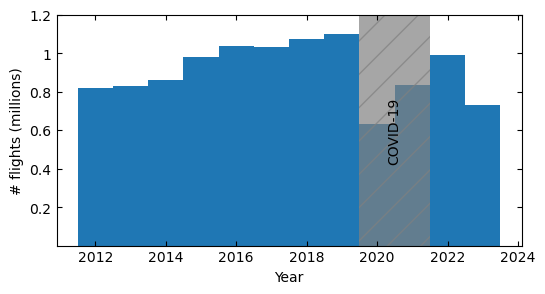

In [247]:
plt.figure(figsize=(6,3))
plt.hist(df["FL_DATE"].dt.year, bins=np.arange(2012-0.5,2024+0.5,1))
ticks = [0.2,0.4,0.6,0.8,1,1.2]
plt.yticks([x*1e6 for x in ticks], ticks)
plt.ylim([0,1.2e6])
plt.ylabel("# flights (millions)")
plt.xlabel("Year")
plt.axvspan(2019.5,2021.5,color='gray',hatch='/',alpha=0.7,lw=0)
plt.text(2020.5,0.6e6,"COVID-19",ha='center',va='center',rotation=90)
plt.show()

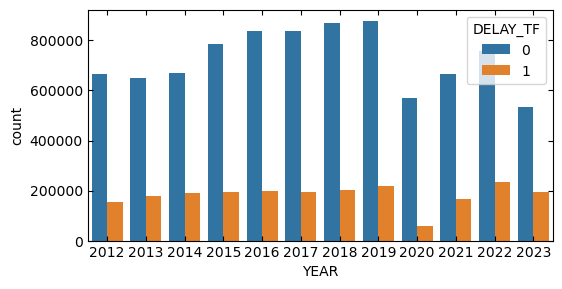

In [250]:
df["YEAR"] = df["FL_DATE"].dt.year.astype(int)
plt.figure(figsize=(6,3))
sns.countplot(df, x="YEAR", hue="DELAY_TF")
plt.show()

The number of flights increased consistently throughout the 2010's, then dipped after (and during, although we don't have the data) the pandemic. Note that 2023 data is incomplete, this is only the first 8 months.

Let's take out pandemic data (2020,2021), and 2023

In [37]:
df = df[~df["FL_DATE"].dt.year.isin([2020,2021,2023])]

<Axes: xlabel='YEAR', ylabel='count'>

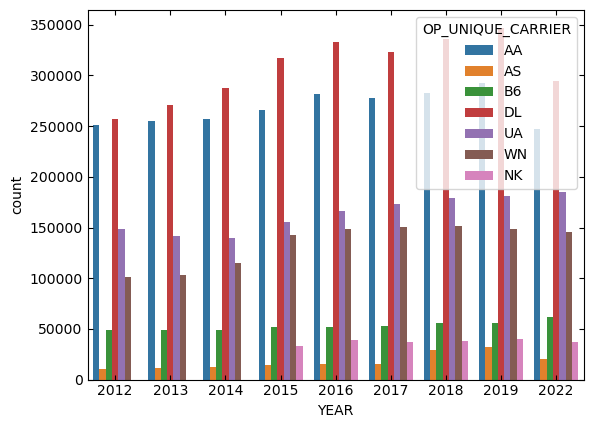

In [39]:
sns.countplot(df, x="YEAR", hue="OP_UNIQUE_CARRIER")

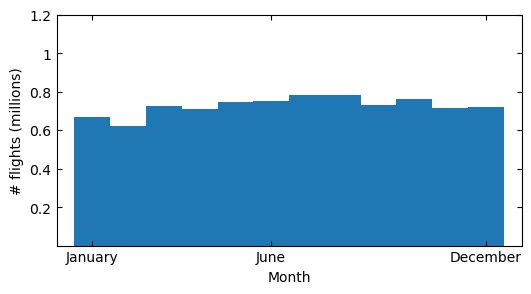

In [40]:
def hist_month():
    plt.figure(figsize=(6,3))
    plt.hist(df["FL_DATE"].dt.month, bins=np.arange(0.5,13.5,1))
    plt.yticks([x*1e6 for x in ticks], ticks)
    plt.xticks([1,6,12],["January","June","December"])
    plt.xlim([0,13])
    plt.ylim([0,1.2e6])
    plt.ylabel(r"# flights (millions)")
    plt.xlabel(r"Month")

hist_month()
plt.show()
# df.groupby(df["DATE"].dt.month).count().plot(kind="bar")

We can add to that the day-to-day submodulation. Write that as fraction of a year.

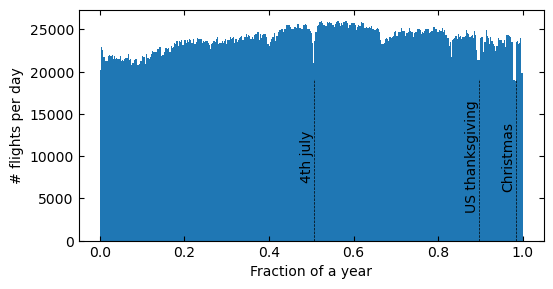

In [41]:
# hist_month()

plt.figure(figsize=(6,3))
plt.hist(df["FRAC_YEAR"],bins=365)

# holidays
for md, name in zip(((7,4),(11,23),(12,25)), ("4th july", "US thanksgiving", "Christmas")):
    m,d = md
    dt = datetime.date(2000,m,d)-datetime.date(2000,1,1)
    frac = dt/pd.to_timedelta(365, unit='D')
    plt.axvline(frac, color='k', ls='--', lw=0.5, ymax=0.7)
    plt.text(frac, 10000, name, ha="right", va="center", rotation=90)

plt.ylabel(r"# flights per day")
plt.xlabel(r"Fraction of a year")

# Scale to year
# plt.hist(df["FRAC_YEAR"]*12+0.5,bins=365)
# plt.xticks([1,6,12],["January","June","December"])
# plt.axvline()

plt.show()

Looks like we can see holidays in this data

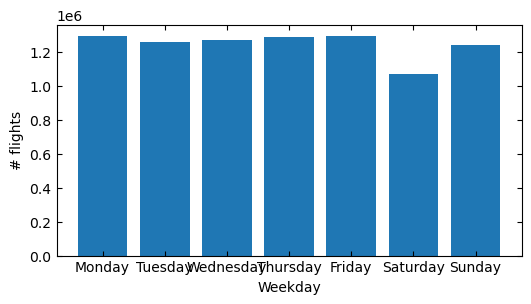

In [42]:
df['weekday'] = df['FL_DATE'].dt.day_name()
weekday_counts = df['weekday'].value_counts()
weekday_counts = weekday_counts.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot the histogram
plt.figure(figsize=(6,3))
plt.bar(weekday_counts.index, weekday_counts.values)
plt.xlabel('Weekday')
plt.ylabel(r"# flights")
plt.show()

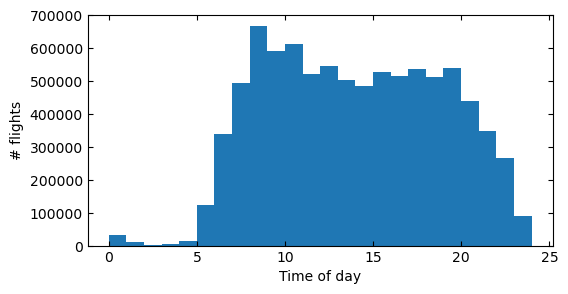

In [43]:
# Number of flights throughout the day. Get frac_day
df['FRAC_DAY'] = (df['FL_DATE'] - df['FL_DATE'].dt.floor('D')) / pd.to_timedelta('1D')
plt.figure(figsize=(6,3))
plt.hist(df['FRAC_DAY']*24, bins=24)
plt.xlabel('Time of day')
plt.ylabel(r"# flights")
plt.show()

Now that we have an understanding of when flights happen, we can start looking into delays.

## Delays

If delay is above some threshold (15min), the flights is considered delayed.

In [44]:
delay_thresh=15.
df = df.assign(DELAY_TF=pd.Series(df['DEP_DELAY']>delay_thresh).values.astype(int))

Delayed flights fraction per carrier


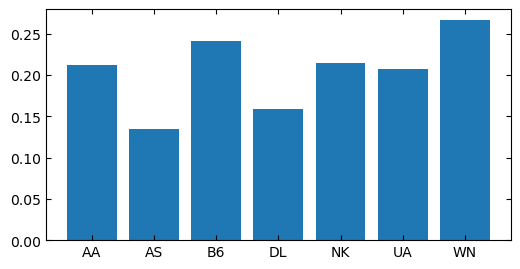

In [45]:
print("Delayed flights fraction per carrier")
carriers=np.unique(df['OP_UNIQUE_CARRIER'])
fracs = []
for carrier in carriers:
    df_car=df.loc[df['OP_UNIQUE_CARRIER']==carrier]
    frac = len(df_car.loc[df_car['DELAY_TF']==1])/len(df_car)
#     print(f"{carrier}: {frac:.2f}")
    fracs.append(frac)
    
plt.figure(figsize=(6,3))
plt.bar(carriers, fracs)
plt.show()

Carrier seems to matter. In particular, WN (SouthWest) has many late flights, AS (Alaska) has few.

In [50]:
# Another way to see this, but it's not normalized so not as clear
# sns.countplot(df, x="OP_UNIQUE_CARRIER", hue="DELAY_TF")

In [62]:
# Did any carrier get worse over time?
years = df["YEAR"].unique()
fracs = np.zeros((len(carriers), len(years)))
for i in range(len(carriers)):
    for j in range(len(years)):
        df_at = df.loc[(df['OP_UNIQUE_CARRIER']==carriers[i]) & (df['YEAR']==years[j])]
        if len(df_at)>0:
            fracs[i,j] = len(df_at.loc[df['DELAY_TF']==1])/len(df_at)

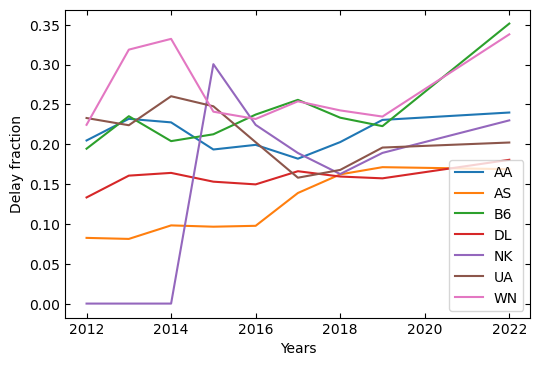

In [66]:
plt.figure(figsize=(6,4))
plt.xlabel('Years')
plt.ylabel('Delay fraction')
for i in range(len(fracs)):
    plt.plot(years, fracs[i], label=carriers[i])
plt.legend()
plt.show()

Some carriers got worse over time, especially B6 (JetBlue) and WN (SouthWest) post-pandemic.

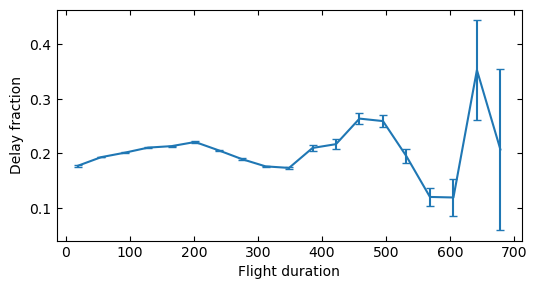

In [85]:
bins=np.linspace(0,np.max(df['AIR_TIME']),20)
medbins,fracs,CIs=[],[],[]
count_=1

# Consider the 95% confidence interval
# https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval
z = 1.96

for el in bins:
    if count_<len(bins):
        df_at = df.loc[(df['AIR_TIME']>el)&(df['AIR_TIME']<bins[count_])]
        N = len(df_at)
        p = len(df_at.loc[df_at['DELAY_TF']==1])/N
        CI = z * np.sqrt(p*(1-p)/N)
#         print(f"air time {el:.2f} - {bins[count_]:.2f} : {frac:.2f} +/- {CI:.2f}")

        CIs.append(CI)
        medbins.append(0.5*(el+bins[count_]))
        fracs.append(p)
    count_+=1

plt.figure(figsize=(6,3))
# plt.scatter(medbins,fracs)
plt.errorbar(medbins,fracs,CIs,capsize=3)
plt.xlabel("Flight duration")
plt.ylabel("Delay fraction")
plt.show()

There is some interesting modulation with flight duration

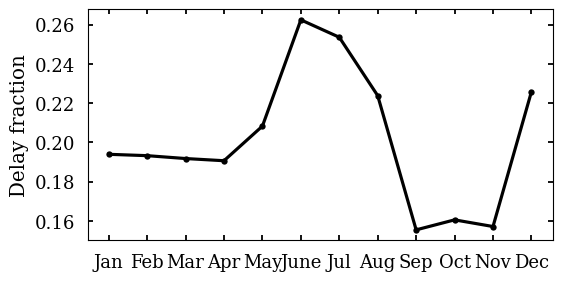

In [231]:
bins=np.linspace(0,1,13)
medbins,fracs=[],[]
count_=1

for el in bins:
    if count_<len(bins):
        df_at=df.loc[(df['FRAC_YEAR']>el)&(df['FRAC_YEAR']<bins[count_])]
        N = len(df_at)
        p = len(df_at.loc[df_at['DELAY_TF']==1])/N
        medbins.append(0.5*(el+bins[count_]))
        fracs.append(p)
    count_+=1

plt.figure(figsize=(6,3))
plt.plot(medbins,fracs,'k.-')
# plt.xlabel("Fraction year")
plt.xticks(medbins, ["Jan","Feb","Mar","Apr","May","June","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.ylabel("Delay fraction")
plt.show()

Delays peak in the summer and in december, and are much less frequent in the fall.

Now check by airports (origin and destination)

In [88]:
airports = pd.read_csv("../data/AIRPORT_ID.csv")
airports.info()

airports_dict = airports.set_index('Code').to_dict()['Description']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6659 entries, 0 to 6658
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Code         6659 non-null   int64 
 1   Description  6659 non-null   object
dtypes: int64(1), object(1)
memory usage: 104.2+ KB


In [212]:
# sorted counts of flights per airport
orig_counts = df['ORIGIN_AIRPORT_ID'].value_counts().to_dict()
dest_counts = df['DEST_AIRPORT_ID'].value_counts().to_dict()

print("Top origin airports")
for orig in orig_counts.keys():
    print(airports_dict[orig], " : ", orig_counts[orig])
    
print("\nTop destination airports")
for dest in list(dest_counts.keys())[:10]:
    print(airports_dict[dest], " : ", dest_counts[dest])

Top origin airports
Atlanta, GA: Hartsfield-Jackson Atlanta International  :  2496907
Dallas/Fort Worth, TX: Dallas/Fort Worth International  :  1477737
Los Angeles, CA: Los Angeles International  :  1371894
Denver, CO: Denver International  :  1293355
Chicago, IL: Chicago O'Hare International  :  1284575
New York, NY: John F. Kennedy International  :  791806

 Top destination airports
San Francisco, CA: San Francisco International  :  322473
Los Angeles, CA: Los Angeles International  :  320815
Las Vegas, NV: Harry Reid International  :  269752
Boston, MA: Logan International  :  235484
Chicago, IL: Chicago O'Hare International  :  231888
Seattle, WA: Seattle/Tacoma International  :  230126
Orlando, FL: Orlando International  :  229357
Dallas/Fort Worth, TX: Dallas/Fort Worth International  :  224818
New York, NY: LaGuardia  :  222749
Atlanta, GA: Hartsfield-Jackson Atlanta International  :  217971


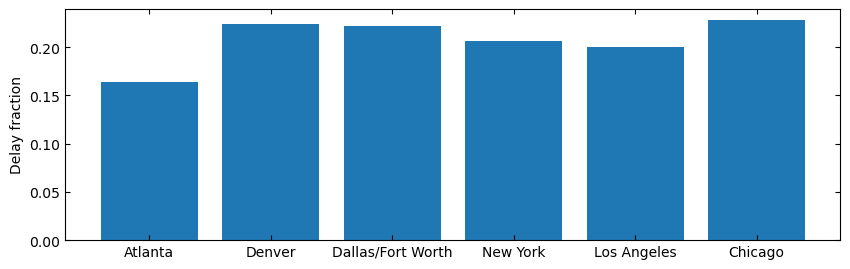

In [109]:
frac = []
origins = df['ORIGIN_AIRPORT_ID'].unique()
for orig in origins:
    df_at = df.loc[df['ORIGIN_AIRPORT_ID'] == orig]
    frac.append(len(df_at.loc[df['DELAY_TF']==1])/len(df_at))
    
plt.figure(figsize=(10,3))
# plt.bar([str(o) for o in origins], frac)
names = [airports_dict[o].split(',')[0] for o in origins]
plt.bar(names, frac)
# plt.xticks(range(names), names, rotation=90)
plt.ylabel("Delay fraction")
plt.show()

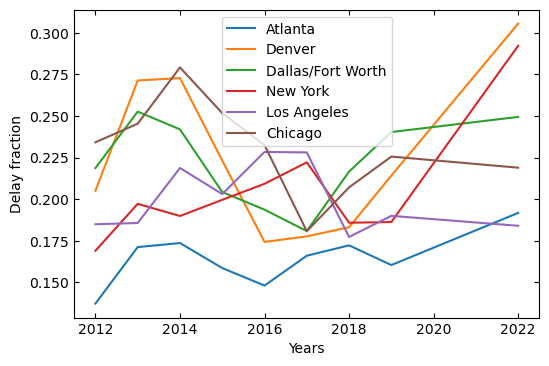

In [110]:
# Worse over time?
fracs = np.zeros((len(origins), len(years)))
for i in range(len(origins)):
    for j in range(len(years)):
        df_at = df.loc[(df['ORIGIN_AIRPORT_ID']==origins[i]) & (df['YEAR']==years[j])]
        if len(df_at)>0:
            fracs[i,j] = len(df_at.loc[df['DELAY_TF']==1])/len(df_at)
            
plt.figure(figsize=(6,4))
plt.xlabel('Years')
plt.ylabel('Delay fraction')
for i in range(len(fracs)):
    plt.plot(years, fracs[i], label=names[i])
plt.legend()
plt.show()

11292 (Denver) and 12478 (JFK) have gotten really bad post-pandemic!!

What about destinations?

In [226]:
frac = []

# destinations = df['DEST_AIRPORT_ID'].unique()

# Go in order of value counts so the plot can be sorted by number of flights to that airport
destinations = list(dest_counts.keys())

is_in_orig = []
for dest in destinations:
    df_at = df.loc[df['DEST_AIRPORT_ID'] == dest]
    frac.append(len(df_at.loc[df['DELAY_TF']==1])/len(df_at))
    
    if dest in df['ORIGIN_AIRPORT_ID'].unique():
        is_in_orig.append(True)
    else:
        is_in_orig.append(False)

frac = np.array(frac)

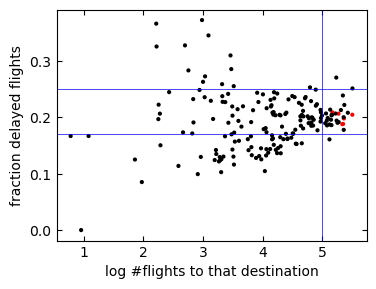

In [243]:
colors = ['r' if is_in_orig[k] else 'k' for k in range(len(destinations))]
plt.figure(figsize=(4,3))
plt.xlabel("log #flights to that destination")
plt.ylabel("fraction delayed flights")
flight_counts = np.array(list(dest_counts.values()))
plt.scatter(np.log10(flight_counts), frac, s=4, c=colors)

#thresholds
plt.axvline(5,color='b',lw=0.5)
plt.axhline(0.25,color='b',lw=0.5)
plt.axhline(0.17,color='b',lw=0.5)

plt.show()

There are a few outliers, but they are where there are not many flights.

In [219]:
flight_counts > 1e4

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [228]:
frac=np.array(frac)
print(sum(frac>0.3))
print(sum(frac<0.1))
print(sum((frac>0.3) | (frac<0.1)))
outlier_fracs = frac[(frac>0.3) | (frac<0.1)]
outlier_dests = np.array(destinations)[(frac>0.3) | (frac<0.1)]
print(len(outlier_dests))

for i in range(len(outlier_fracs)):
    print(f"{airports_dict[outlier_dests[i]]}, {outlier_fracs[i]:.2f}")

6
3
9
9
Amarillo, TX: Rick Husband Amarillo International, 0.31
Worcester, MA: Worcester Regional, 0.34
Fairbanks, AK: Fairbanks International, 0.37
Shreveport, LA: Shreveport Regional, 0.10
Bend/Redmond, OR: Roberts Field, 0.33
Bakersfield, CA: Meadows Field, 0.33
San Luis Obispo, CA: San Luis County Regional, 0.37
Great Falls, MT: Great Falls International, 0.09
Montgomery, AL: Montgomery Regional, 0.00


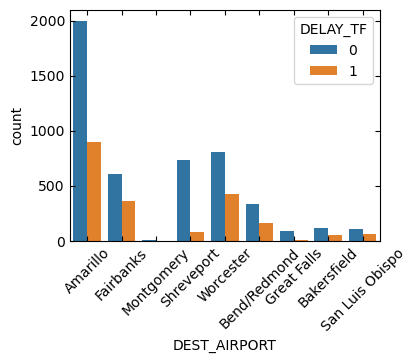

In [230]:
df_outliers = df[df['DEST_AIRPORT_ID'].isin(outlier_dests)][['DEST_AIRPORT_ID','DELAY_TF']]

# names = [airports_dict[o].split(',')[0] for o in origins]
# data['FL_DATE'] = pd.to_datetime(data.apply(lambda row: row.FL_DATE.split()[0], axis=1), format="%m/%d/%Y") + \

df_outliers['DEST_AIRPORT'] = df_outliers.apply(lambda row: airports_dict[row.DEST_AIRPORT_ID].split(',')[0], axis=1)

plt.figure(figsize=(4,3))
plot = sns.countplot(df_outliers, x='DEST_AIRPORT', hue='DELAY_TF')
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plt.show()

Let's instead look at the outliers but only at airports with >1e4 flights

San Francisco, CA: San Francisco International, 0.25
Newark, NJ: Newark Liberty International, 0.27
Charlotte, NC: Charlotte Douglas International, 0.16


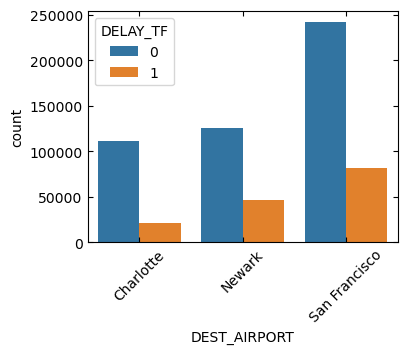

In [244]:
_slice = (flight_counts>1e5) & ((frac>0.25) | (frac<0.17))
outlier_fracs = frac[_slice]
outlier_dests = np.array(destinations)[_slice]

df_outliers = df[df['DEST_AIRPORT_ID'].isin(outlier_dests)][['DEST_AIRPORT_ID','DELAY_TF']]
df_outliers['DEST_AIRPORT'] = df_outliers.apply(lambda row: airports_dict[row.DEST_AIRPORT_ID].split(',')[0], axis=1)

for i in range(len(outlier_fracs)):
    print(f"{airports_dict[outlier_dests[i]]}, {outlier_fracs[i]:.2f}")

plt.figure(figsize=(4,3))
plot = sns.countplot(df_outliers, x='DEST_AIRPORT', hue='DELAY_TF')
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plt.show()

# Other stuff
### If the flight is delayed, by how much?

In [221]:
frac>0.25

TypeError: '>' not supported between instances of 'list' and 'float'

(0.0, 200.0)

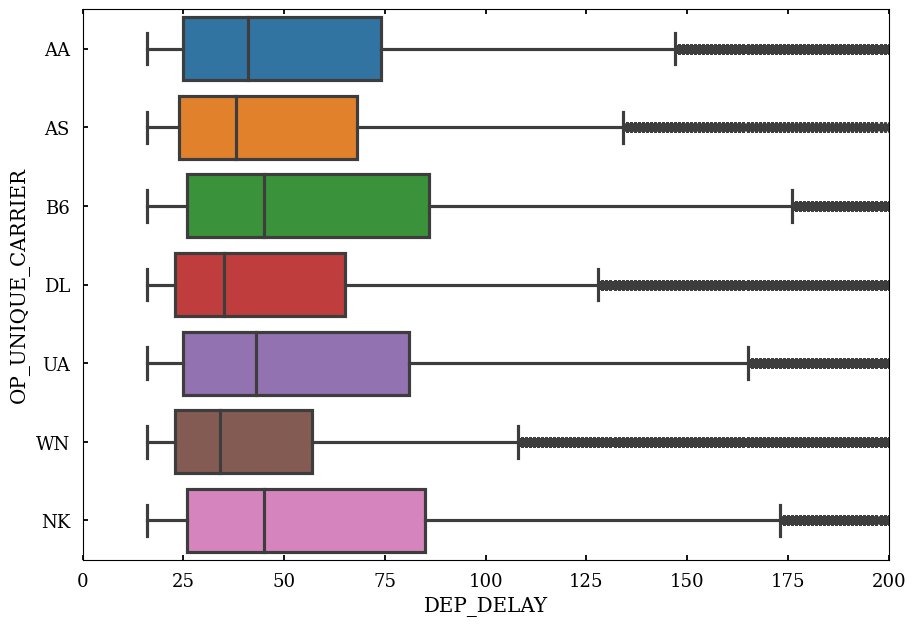

In [239]:
fig, ax = plt.subplots()
sns.boxplot(data=df.loc[df['DELAY_TF']==1], x="DEP_DELAY", y="OP_UNIQUE_CARRIER", ax=ax)
ax.set_xlim([0,200])

/Users/simon/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


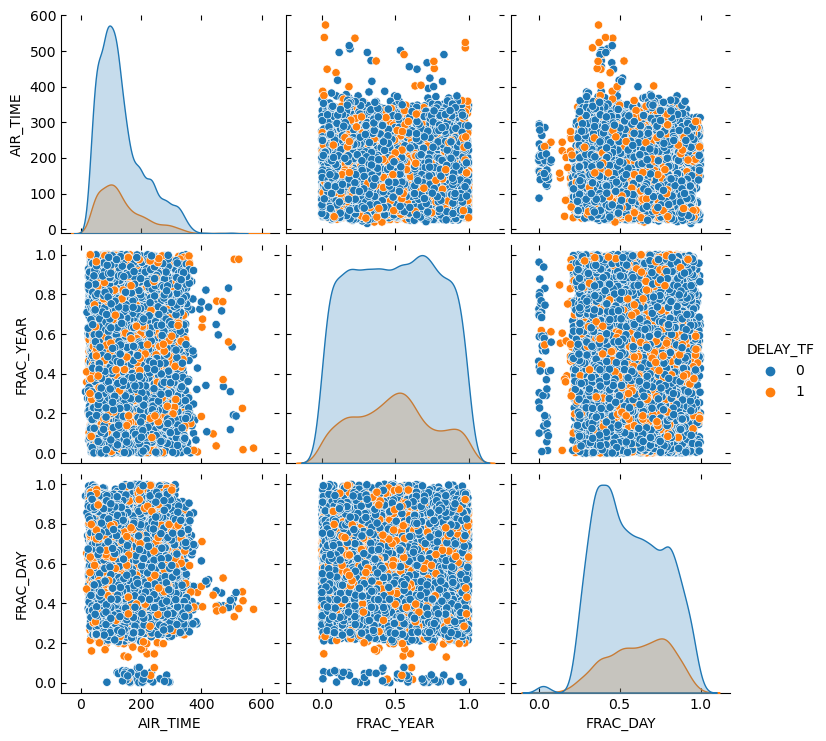

In [31]:
# Seaborn pairplot

small_df = df.sample(10000)
small_df = pd.get_dummies(small_df, 
                          columns=['OP_UNIQUE_CARRIER','ORIGIN_AIRPORT_ID'], 
                          drop_first=True, dtype=int)

# columns = ['AIR_TIME','FRAC_YEAR','OP_UNIQUE_CARRIER_WN','OP_UNIQUE_CARRIER_DL']

columns = ['AIR_TIME','FRAC_YEAR','FRAC_DAY']

# sns.pairplot(data = df.loc[df['FL_DATE'].dt.year==2022], x_vars=columns, y_vars=columns, hue='DELAY_TF')
sns.pairplot(data = small_df, x_vars=columns, y_vars=columns, hue='DELAY_TF')
plt.show()